In [1]:
import sys, os
sys.path.append('../')
import numpy as np
from tqdm.notebook import tqdm
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
from machine_data import v2366_v2
from src.simulation.utils import get_parser_for_bii
from scipy.interpolate import interp1d

/home/gubaidulin/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/gubaidulin/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


mbtrack2 version 0.5.0.89
--------------------------------------------------
If used in a publication, please cite mbtrack2 paper and the zenodo archive for the corresponding code version (and other papers for more specific features).
[1] A. Gamelin, W. Foosang, N. Yamamoto, V. Gubaidulin and R. Nagaoka, “mbtrack2”. Zenodo, Mar. 25, 2024. doi: 10.5281/zenodo.10871040.
[2] A. Gamelin, W. Foosang, and R. Nagaoka, “mbtrack2, a Collective Effect Library in Python”, presented at the 12th Int. Particle Accelerator Conf. (IPAC'21), Campinas, Brazil, May 2021, paper MOPAB070.




In [2]:
ring2 = v2366_v2(IDs='open', V_RF=1.7e6)
print(ring2.optics.local_beta)
print(BETA_X_SMOOTH, BETA_Y_SMOOTH)
BETA_X_SMOOTH = ring2.optics.local_beta[0]
BETA_Y_SMOOTH = ring2.optics.local_beta[1]

[3.288 4.003]
5.58 3.92


In [3]:
def run_pyht(n_macroparticles,
        gap_length=1,
        n_turns=int(3000),
        n_segments=50,
        n_gaps=4,
        h_rf=416,
        interaction_model='weak',
        interaction_model_ions='weak',
        smooth=True,
        charge_variation=0.0,
        pressure_variation=0.0,
        average_pressure=2.4e13,
        beam_current=500e-3):
    n_macroparticles_ions = int(1e5)
    from PyHEADTAIL.general import pmath as pm
    from PyHEADTAIL.ion_cloud.ion_cloud import BeamIonElement
    from PyHEADTAIL.monitors.monitors import BunchMonitor
    from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
    from PyHEADTAIL.trackers.detuners import Chromaticity
    from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
    from PyHEADTAIL.general.printers import SilentPrinter
    from PyHEADTAIL.particles import generators, particles
    from PyHEADTAIL.impedances.wakes import CircularResistiveWall, WakeField
    from PyHEADTAIL.particles.slicing import UniformBinSlicer
    import PyHEADTAIL
    N_MACROPARTICLES = int(1e3)
    N_TURNS = int(20)
    H_RF = 416
    N_SEGMENTS = int(1)
    PHI_RF = np.arccos(U_LOSS/V_RF) if (GAMMA**-2-GAMMA_T**-2) < 0 else pi+np.arccos(U_LOSS/V_RF)
    PHI_RF = 0
    FOLDER_PATH = '/home/gubaidulin/scripts/tracking/bii_tracking/'
    if interaction_model_ions == 'PIC':
        interaction_model = 'PIC'
    else:
        interaction_model = 'weak'
    folder = '/home/gubaidulin/scripts/tracking/bii_tracking/data/test/'
    os.makedirs(folder, exist_ok=True)
    np.random.seed(42)

    long_map = RFSystems(
        CIRCUMFERENCE,
        [h_rf],
        [V_RF],
        [PHI_RF],
        [ALPHA_0],
        GAMMA,
        mass=m_e,
        charge=e
    )
    electron_bunch_list = []
    monitor_list = []
    if smooth:
        eta_x_0 = [0]
        alpha_x_0 = ALPHA_X_SMOOTH
        alpha_x_0 = ALPHA_Y_SMOOTH

    else:
        eta_x_0 = np.load(FOLDER_PATH+'lattice_functions/eta_x.npy')

    bunch_current = beam_current/(h_rf-n_gaps*gap_length)
    intensity_per_bunch = bunch_current/e*2*pi/OMEGA_REV
    for ind, h in enumerate(range(h_rf)):
        np.random.seed(42)
        electron_bunch = generators.ParticleGenerator(macroparticlenumber=n_macroparticles,
                                                      intensity=intensity_per_bunch,
                                                      charge=e, gamma=GAMMA, mass=m_e,
                                                      circumference=CIRCUMFERENCE,
                                                      distribution_x=generators.gaussian2D(
                                                          EPSILON_X),
                                                      alpha_x=ALPHA_X_SMOOTH, beta_x=BETA_X_SMOOTH,
                                                      D_x=eta_x_0[0], D_y=0,
                                                      distribution_y=generators.gaussian2D(
                                                          EPSILON_Y),
                                                      alpha_y=ALPHA_Y_SMOOTH, beta_y=BETA_Y_SMOOTH,
                                                      distribution_z=generators.gaussian2D_asymmetrical(
                                                          SIGMA_Z, SIGMA_DP),
                                                      printer=SilentPrinter()
                                                      ).generate()
        if charge_variation != 0:
            np.random.seed(ind)
            electron_bunch.intensity = np.random.normal(
                loc=intensity_per_bunch, scale=0.01*charge_variation*intensity_per_bunch, size=1)
        electron_bunch.y -= electron_bunch.mean_y()
        electron_bunch.x -= electron_bunch.mean_x()
        electron_bunch.yp -= electron_bunch.mean_yp()
        electron_bunch.xp -= electron_bunch.mean_xp()
        electron_bunch.z += h*CIRCUMFERENCE/h_rf
        electron_bunch_list.append(electron_bunch)
        filename = folder+'BM(n_bunch={0:})'.format(int(h))
        bunch_monitor = BunchMonitor(filename,
                                     n_steps=int(n_segments*n_turns),
                                     write_buffer_every=1,
                                     buffer_size=10,
                                     parameters_dict=None)
        monitor_list.append(bunch_monitor)
    train_length = h_rf//n_gaps
    for i in range(gap_length):
        for j in range(n_gaps):
            electron_bunch_list[train_length*j-i].intensity = 0

    s = np.arange(0, n_segments + 1) * CIRCUMFERENCE / n_segments
    if smooth == 'True':
        # print('smooth focusing')
        alpha_x, alpha_y = ALPHA_X_SMOOTH * \
            np.ones(n_segments), ALPHA_Y_SMOOTH * np.ones(n_segments)
        beta_x, beta_y = BETA_X_SMOOTH * \
            np.ones(n_segments), BETA_Y_SMOOTH * np.ones(n_segments)
        D_x, D_y = np.zeros(n_segments),  np.zeros(n_segments)
    else:
        try:
            print('lattice function sampling')
            data_files = ['s', 'beta_x', 'beta_y',
                          'alpha_x', 'alpha_y', 'eta_x', 'eta_y']
            data = {}
            for file in data_files:
                data[file] = np.load(
                    '/home/dockeruser/fbii_pyht_tracking/lattice_functions/' + file + '.npy')

            s = data['s'][::len(data['s']) // n_segments]
            beta_x = data['beta_x'][::len(data['beta_x']) // n_segments]
            beta_y = data['beta_y'][::len(data['beta_y']) // n_segments]
            alpha_x = data['alpha_x'][::len(data['alpha_x']) // n_segments]
            alpha_y = data['alpha_y'][::len(data['alpha_y']) // n_segments]
            eta_x = data['eta_x'][::len(data['eta_x']) // n_segments]
            eta_y = data['eta_y'][::len(data['eta_y']) // n_segments]

            D_x, D_y = np.array(eta_x), np.array(eta_y)
            alpha_x, alpha_y = np.array(alpha_x), np.array(alpha_y)
            beta_x, beta_y = np.array(beta_x), np.array(beta_y)
        except:
            raise RunTimeError(
                'There is some error with your lattice functions. Check names and sampling. The number of points in the files should be larger than number of segments in the code.')
    chroma = Chromaticity(Qp_x=[0], Qp_y=[0])
    trans_map = TransverseMap(s, alpha_x, beta_x, D_x,
                              alpha_y, beta_y, D_y, Q_X, Q_Y, [chroma])

    trans_one_turn = [m for m in trans_map]
    res_wall = CircularResistiveWall(pipe_radius=10e-3,
    resistive_wall_length=1,
    conductivity=1/1e-6,
    dt_min= np.diff(np.linspace(0, 200e-12, 10000))[0],
    n_turns_wake=1,
    )
    wake_slicer = UniformBinSlicer(
        n_slices=65, z_cuts=(-4*electron_bunch_list[0].sigma_z(), 4*electron_bunch_list[0].sigma_z()))
    wake_field = WakeField(wake_slicer, res_wall)
    
    beam_ion_elements = []
    for ind, m in enumerate(trans_one_turn):
        np.random.normal(ind)
        vacuum_pressure = np.random.normal(
            loc=average_pressure, scale=0.01*pressure_variation*average_pressure, size=1)
        monitor_name = monitor_name = folder + \
            'IM(ind={0:})'.format(int(ind)) if ind == 1 else None
        print('For ion elements with index {:} vacuum pressure is {:.1e}'.format(
            ind, vacuum_pressure[0]))
        beam_ion_elements.append(BeamIonElement(dist_ions='GS',
                                                monitor_name=monitor_name,
                                                set_aperture=True,
                                                n_segments=n_segments,
                                                n_macroparticles_max=n_macroparticles_ions,
                                                n_steps=int(h_rf*n_turns),
                                                interaction_model=interaction_model,
                                                interaction_model_ions=interaction_model_ions,
                                                n_g=vacuum_pressure[0])
                                 )
    trans_one_turn = [item for sublist in zip(
        trans_one_turn, beam_ion_elements) for item in sublist]
    ion_intensity = []
    charge_per_mp = []
    for turn in tqdm(range(n_turns)):
        for bunch_index, electron_bunch in enumerate(electron_bunch_list):
            for index, m_ in enumerate((trans_one_turn)):
                m_.track(electron_bunch_list[bunch_index])
                if index % 2 == 0:
                    monitor_list[bunch_index].dump(
                        electron_bunch_list[bunch_index])
                else:
                    ion_intensity.append(m_.ion_beam.intensity)
                    charge_per_mp.append(m_.ion_beam.charge_per_mp)
            # wake_field.track(electron_bunch_list[bunch_index])
            long_map.track(electron_bunch_list[bunch_index])
    return ion_intensity, charge_per_mp, electron_bunch_list


In [4]:
def run_mbtrack2(ring, beam_current=500e-3, mp_per_bunch=1e3, turns=25):
    from mbtrack2 import Synchrotron, Electron
    from mbtrack2.utilities import Optics
    from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap, RFCavity
    from mbtrack2.tracking.monitors import BeamMonitor
    from mbtrack2.tracking import Beam, Bunch
    from mbtrack2.tracking.element import TransverseMap, TransverseMapSector, transverse_map_sector_generator
    from mbtrack2.tracking.beam_ion_effects import BeamIonElement
    from mbtrack2 import WakePotential
    from mbtrack2 import CircularResistiveWall
    particle = Electron()
    chro = [0, 0]
    ring2 = v2366_v2(IDs='open', V_RF=1.7e6)
    ring = Synchrotron(
        h=ring2.h,
        optics=ring2.optics,
        particle=particle,
        L=ring2.L,
        E0=ring2.E0,
        ac=ring2.ac,
        U0=ring2.U0,
        tau=ring2.tau,
        emit=[ring2.emit[0], 0.3*ring2.emit[0]],
        tune=ring2.tune,
        sigma_delta=ring2.sigma_delta,
        sigma_0=ring2.sigma_0,
        chro=chro,
    )

    np.random.seed(42)
    mybeam = Beam(ring)
    is_mpi = False
    bunch_current = beam_current/ring.h
    filling_pattern = np.ones(ring.h) * bunch_current
    mybeam.init_beam(
        filling_pattern,
        current_per_bunch=bunch_current,
        mp_per_bunch=mp_per_bunch,
        track_alive=False,
        mpi=is_mpi,
    )
    mybeam.bunch_list[0].charge = 0
    # mybeam.bunch_list[52].charge = 0
    mybeam.bunch_list[104].charge = 0
    # mybeam.bunch_list[156].charge = 0
    mybeam.bunch_list[208].charge = 0
    # mybeam.bunch_list[260].charge = 0
    mybeam.bunch_list[312].charge = 0
    # mybeam.bunch_list[364].charge = 0
    
    for bunch in mybeam.bunch_list:
        for stat in ['x', 'y', 'xp', 'yp']:
            bunch[stat] -= bunch[stat].mean()
    
    
    long_map = LongitudinalMap(ring)
    rf = RFCavity(ring, m=1, Vc=V_RF, theta=np.arccos(ring.U0 / V_RF))

    beam_monitor = BeamMonitor(ring.h,
                               save_every=1,
                               buffer_size=1,
                               total_size=turns,
                               file_name='/home/gubaidulin/scripts/tracking/bii_tracking/data/test/beam_monitor',
                               mpi_mode=False)    
    sr = SynchrotronRadiation(ring, switch=[1, 1, 1])
    trans_map = TransverseMap(ring)
    # time = np.linspace(0, 200e-12, 10000) # Time points where the wake function will be evaluated in [s].
    # frequency = np.linspace(0.1e6, 50e9, 10000) # Frequency points where the impedance will be evaluated in [Hz].
    # length = 1 # Beam pipe length in [m].
    # rho = 1e-6 # Resistivity in [ohm.m].
    # radius = 10e-3 # Beam pipe radius in [m].
    # exact = True # If False, approxmiated formulas are used for the wake function computations.

    # rw = CircularResistiveWall(time, frequency, length, rho, radius, exact)
    # wp = WakePotential(ring, wakefield=rw, n_bin=60)
    beam_ion_element = BeamIonElement(ion_mass=28*m_p,
                                     ion_charge=e,
                                     ionization_cross_section=1.78e-22,
                                     residual_gas_density=2.4e13,
                                     ring=ring,
                                     ion_field_model="strong",
                                     electron_field_model="weak",
                                     bunch_spacing=0.85,
                                     ion_element_length=ring.L,
                                     ion_beam_monitor_name=None,
                                     use_ion_phase_space_monitor=False,
                                     x_radius=5*mybeam[0]['x'].std(),
                                     y_radius = 5*mybeam[0]['y'].std(),
                                     n_steps=turns
                                    )
    ion_density = []
    charge_per_mp = []
    mp_number = []
    for i in tqdm(range(turns)):
        long_map.track(mybeam)
        rf.track(mybeam)
        trans_map.track(mybeam)
        for bunch in mybeam.bunch_list:
            beam_ion_element.track(bunch)
            ion_density.append(beam_ion_element.ion_beam.charge)
            mp_number.append(beam_ion_element.ion_beam.mp_number)
            charge_per_mp.append(beam_ion_element.ion_beam.charge_per_mp)
        # wp.track(mybeam)
        # sr.track(mybeam)
        beam_monitor.track(mybeam)
    beam_monitor.close()
    return mybeam, ion_density, mp_number, charge_per_mp

In [5]:
ring = v2366_v2(IDs="open", V_RF=1.8e6)
print(ring.E0*e)

4.4059857435e-10


In [9]:
# %%prun
# %%timeit -n 1 -r 1
mybeam, ion_density, mp_number, charge_per_mp = run_mbtrack2(ring, beam_current=500e-3, mp_per_bunch=5e3, turns=100)

In [6]:
import cProfile
cProfile.run('run_mbtrack2(ring, beam_current=500e-3, mp_per_bunch=5e3, turns=100)', 'restats')

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
import pstats
from pstats import SortKey
p = pstats.Stats('restats')
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(15)
print(150*'=')
p.strip_dirs().sort_stats(SortKey.TIME).print_stats(15)

Fri Jun 14 10:19:55 2024    restats

         50192305 function calls (50182925 primitive calls) in 273.717 seconds

   Ordered by: cumulative time
   List reduced from 796 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      9/1    0.000    0.000  273.717  273.717 {built-in method builtins.exec}
        1    0.004    0.004  273.717  273.717 <string>:1(<module>)
        1    0.288    0.288  273.713  273.713 2623145445.py:1(run_mbtrack2)
    41600    0.150    0.000  147.413    0.004 beam_ion_effects.py:434(track_wrapper)
    41600    0.872    0.000  147.239    0.004 beam_ion_effects.py:593(track)
    83200    2.285    0.000  120.106    0.001 beam_ion_effects.py:534(_get_new_beam_momentum)
    83200    0.895    0.000  117.690    0.001 beam_ion_effects.py:464(_get_efields)
    83200    3.273    0.000   98.724    0.001 particles_electromagnetic_fields.py:141(get_displaced_efield)
    83200    1.084    0.000   94.086    0.001 particles

In [10]:
# %%prun
ion_intensity2, charge_per_mp2, bunch = run_pyht(n_macroparticles=5000, gap_length=1, n_turns=500, n_segments=1, n_gaps=4, h_rf=416,
        interaction_model='strong',
        interaction_model_ions='weak',
        smooth='True',
        charge_variation=0.0,
        pressure_variation=0.0,
        average_pressure=2.4e13,
        beam_current=500e-3)

PyHEADTAIL v1.14.1.72
(dirty git work tree)


For ion elements with index 0 vacuum pressure is 2.4e+13


  0%|          | 0/500 [00:00<?, ?it/s]

(0.1, 1663752.02)

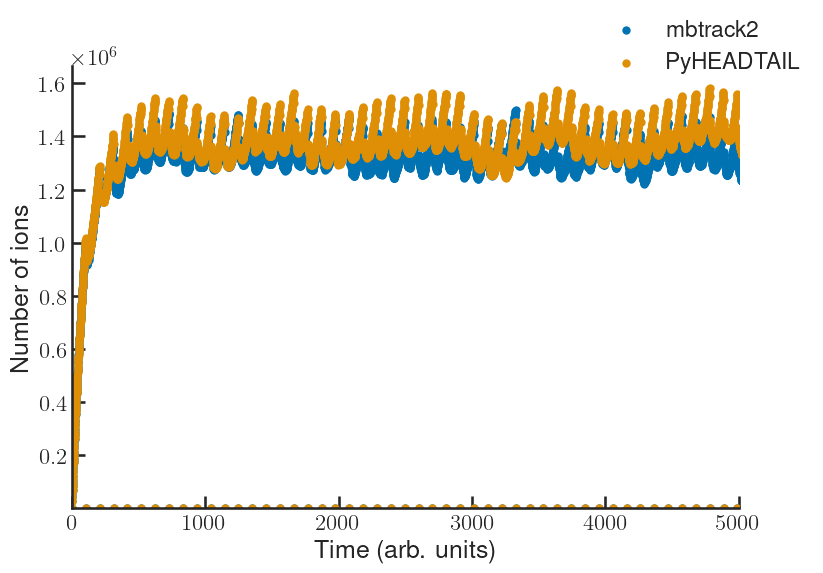

In [11]:
%matplotlib inline
from aps_figures.aps_one_column import *
import matplotlib.pplot as plt
ion_intensity = np.array(ion_density)/e
plt.scatter(range(len(ion_intensity)), ion_intensity, marker='.', label='mbtrack2')
plt.scatter(range(len(ion_intensity2)), ion_intensity2, marker='.', label='PyHEADTAIL')
plt.figlegend()
plt.xlabel('Time (arb. units)')
plt.ylabel('Number of ions')
plt.xlim(0, 5000)
plt.ylim(0.1, )

In [12]:
%%timeit
mybeam[0].particles['x'].mean()

10.3 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
%%timeit
mybeam[0].particles['x'].std()

39.9 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit
mybeam[0].particles['x'].sum()

5.96 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap, RFCavity
from mbtrack2.tracking.monitors import BeamMonitor
from mbtrack2.tracking import Beam, Bunch
from mbtrack2.tracking.element import TransverseMap, TransverseMapSector, transverse_map_sector_generator
from mbtrack2.tracking.beam_ion_effects import BeamIonElement
beam_ion_element = BeamIonElement(ion_mass=28*m_p,
                                     ion_charge=e,
                                     ionization_cross_section=1.78e-22,
                                     residual_gas_density=2.4e13,
                                     ring=ring,
                                     ion_field_model="strong",
                                     electron_field_model="weak",
                                     bunch_spacing=0.85,
                                     ion_element_length=ring.L,
                                     ion_beam_monitor_name=None,
                                     use_ion_phase_space_monitor=False,
                                     use_aperture=True,
                                     x_radius=5*mybeam[0]['x'].std(),
                                     y_radius = 5*mybeam[0]['y'].std()
                                     )
ebunch = mybeam[1]
# ebunch.charge *= 10

1.0


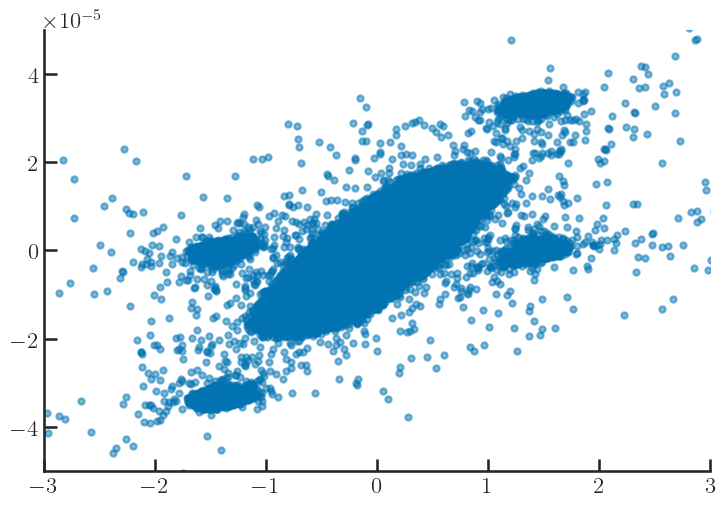

In [13]:
from scipy.constants import e, c
x, xp = beam_ion_element.ion_beam['y'], beam_ion_element.ion_beam['yp'] 
# plt.hist(x, bins=25)
prefactor = -ebunch.charge * (
        e / (beam_ion_element.ion_mass * c**2))
# plt.scatter(x, xp, marker='.', alpha=0.5)
sig_x = mybeam[0]['x'].std()
sig_y = mybeam[0]['y'].std()
np.random.seed(42)
for i in range(5000):
    beam_ion_element.generate_new_ions(electron_bunch=ebunch)
    beam_ion_element.aperture.track(beam_ion_element.ion_beam)
    newxp, newyp = beam_ion_element._get_new_beam_momentum(beam_ion_element.ion_beam, ebunch, prefactor, field_model='weak')
    beam_ion_element._update_beam_momentum(beam_ion_element.ion_beam, newxp, newyp)
    beam_ion_element.track_ions_in_a_drift(.85)
x, xp = beam_ion_element.ion_beam['y'], beam_ion_element.ion_beam['yp'] 
plt.scatter(x/sig_y, xp, marker='.', alpha=0.5)

plt.xlim(-3, 3)
plt.ylim(-5e-5, 5e-5)

print(len(beam_ion_element.ion_beam.alive)/len(beam_ion_element.ion_beam.particles['y']))
plt.show()

In [14]:
beam_ion_element.ion_beam['x'].shape

(47167,)

(47167,)


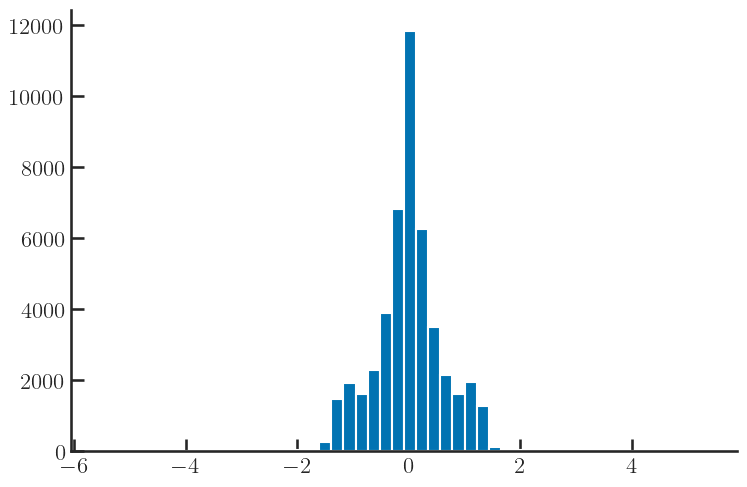

In [15]:
plt.hist(beam_ion_element.ion_beam['x']/sig_x, bins=50)
print(beam_ion_element.ion_beam['x'].shape)

(47167,)

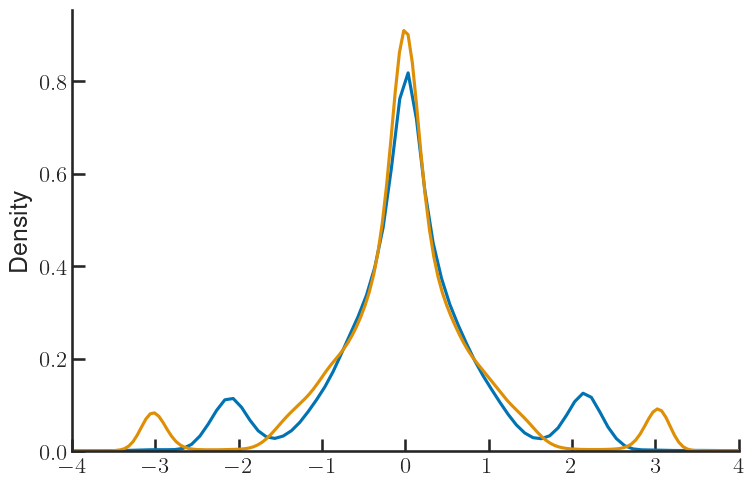

In [16]:
# plt.hist(x/x.std(), bins=50)
# plt.hist(xp/xp.std(), bins=50)
sbs.kdeplot(x/x.std())
sbs.kdeplot(xp/xp.std())
plt.xlim(-4, 4)
x.shape

In [17]:
from PyHEADTAIL.general import pmath as pm
from PyHEADTAIL.ion_cloud.ion_cloud import BeamIonElement
from PyHEADTAIL.monitors.monitors import BunchMonitor
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.detuners import Chromaticity
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
from PyHEADTAIL.general.printers import SilentPrinter
from PyHEADTAIL.particles import generators, particles
from PyHEADTAIL.impedances.wakes import CircularResistiveWall, WakeField
from PyHEADTAIL.particles.slicing import UniformBinSlicer
import PyHEADTAIL
pyht_bi = BeamIonElement(dist_ions='GS',
            monitor_name=None,
            set_aperture=True,
            n_segments=1,
            n_macroparticles_max=int(1e7),
            n_steps=int(416),
            interaction_model='strong',
            interaction_model_ions='weak',
            n_g=2.4e13)
ebb = bunch[1]
ebb.x = mybeam[1]['x']
ebb.y = mybeam[1]['y']

(-5e-05, 5e-05)

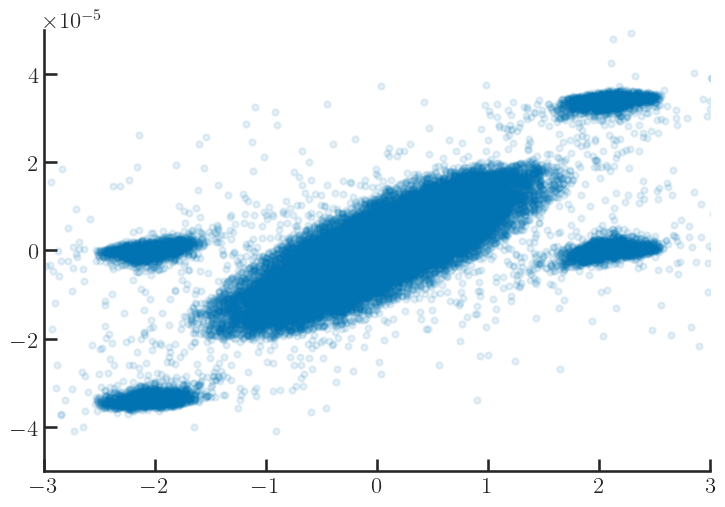

In [18]:
prefactor = -(ebb.intensity *ebb.charge *
                                          pyht_bi.ion_beam.charge /
                                          (pyht_bi.ion_beam.mass * c**2))
np.random.seed(42)
for i in range(5000):
    ION_INTENSITY_PER_ELECTRON_BUNCH = (ebb.intensity *
                                                 pyht_bi.sigma_i * pyht_bi.n_g *
                                                 pyht_bi.L_SEG)
    # np.random.seed(42)
    pyht_bi._generate_ions(electron_bunch=ebb, ion_intensity=ION_INTENSITY_PER_ELECTRON_BUNCH)
    pyht_bi.ions_aperture.track(pyht_bi.ion_beam)
    p_id = np.linspace(0,
                     pyht_bi.ion_beam.y.shape[0] - 1,
                     pyht_bi.ion_beam.y.shape[0],
                     dtype=np.int64)
    newxp, newyp = pyht_bi._get_new_beam_momentum(first_beam=pyht_bi.ion_beam,
                                                    second_beam=ebb,
                                                    prefactor=prefactor,
                                                    p_id=p_id,
                                                    field_model="weak")
    pyht_bi._update_beam_momentum(pyht_bi.ion_beam, p_id, newxp, newyp)
    pyht_bi.track_ions_in_drift(p_id)
x, xp = pyht_bi.ion_beam.y, pyht_bi.ion_beam.yp
sig_x, sig_y = pyht_bi.ion_beam.sigma_y(), pyht_bi.ion_beam.sigma_yp()

plt.scatter(x/sig_x, xp, marker='.', alpha=0.1)
plt.xlim(-3, 3)
plt.ylim(-5e-5, 5e-5)

In [19]:
print(x.shape)

(47533,)


(47533,)


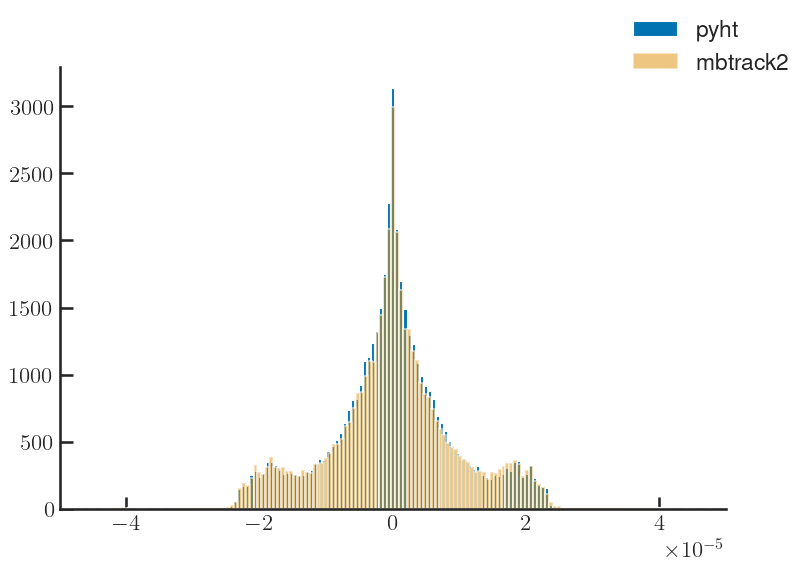

In [20]:
plt.hist(pyht_bi.ion_beam.x, bins=300, label='pyht')
sig_x2 = mybeam[0]['y'].std()
plt.hist(beam_ion_element.ion_beam['x'], bins=300, label='mbtrack2', alpha=0.5)
plt.xlim(-5e-5, 5e-5)
plt.figlegend()
print(x.shape)

(-4.0, 4.0)

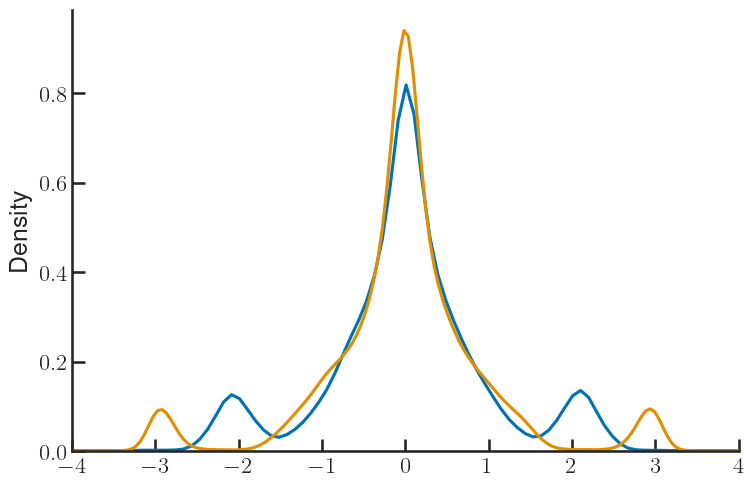

In [21]:
sbs.kdeplot(x/x.std())
sbs.kdeplot(xp/xp.std())
plt.xlim(-4, 4)